In [11]:
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
from app.preprocessing import preprocess_input
import inspect

print(inspect.getsource(preprocess_input))


import pandas as pd
import pickle
import os

def preprocess_input(df, mode='predict'):
    df = df.copy()
    df = pd.get_dummies(df)

    if mode == 'predict':
        # Baca feature names dari model yang sudah disimpan
        path = os.path.join("..", "models", "feature_names.pkl")
        with open(path, "rb") as f:
            trained_features = pickle.load(f)

        # Tambah kolom yang hilang
        for col in trained_features:
            if col not in df.columns:
                df[col] = 0

        # Pastikan urutan kolom sama dengan training
        df = df[trained_features]

    return df



In [45]:
import importlib
import app.preprocessing
importlib.reload(app.preprocessing)
from app.preprocessing import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sys
import os


In [47]:
# 1. Load data
import pandas as pd
df = pd.read_csv('../data/heart_attack_prediction_indonesia.csv')
X = df.drop(columns=['heart_attack'])
y = df['heart_attack']

# 1. Load data
df = pd.read_csv("../data/heart_attack_prediction_indonesia.csv")
X = df.drop(columns=['heart_attack'])
y = df['heart_attack']

# 2. Preprocess
X_processed = preprocess_input(X, mode='train')

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 4. Train model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 5. Save model & feature names
with open("../models/heart_attack_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("../models/feature_names.pkl", "wb") as f:
    pickle.dump(X_train.columns.tolist(), f)

print("✅ Model dan feature names berhasil disimpan.")


# 2. Preprocess
from app.preprocessing import preprocess_input
X_processed = preprocess_input(X, mode='train')

# 3. Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 4. Train model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 5. Save model & feature names
import pickle
with open('../models/heart_attack_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('../models/feature_names.pkl', 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)


✅ Model dan feature names berhasil disimpan.


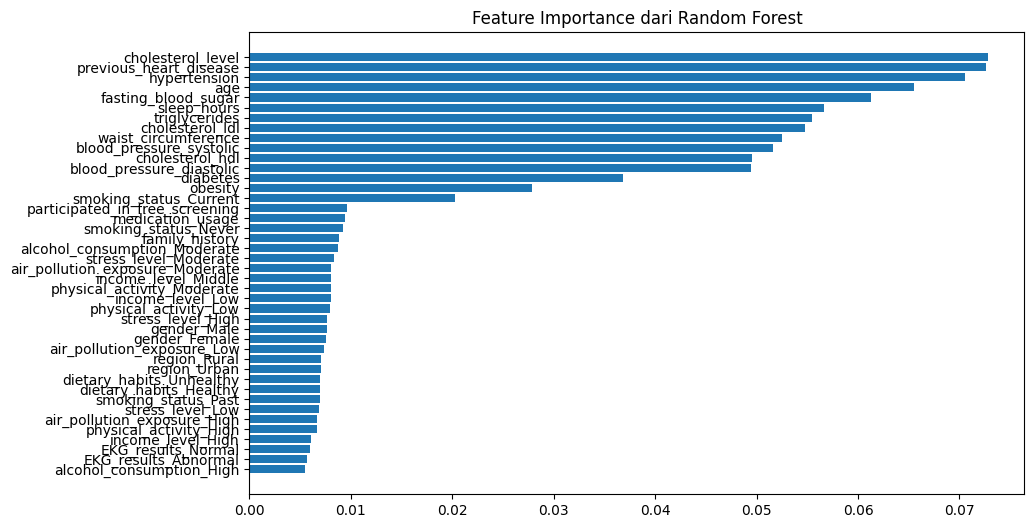

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

importances = model.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance dari Random Forest")
plt.show()


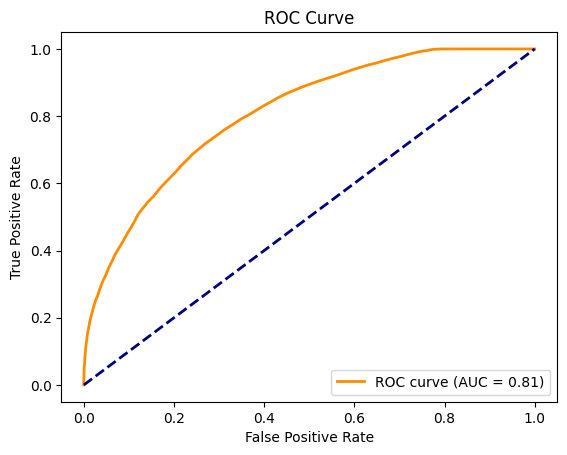

In [49]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


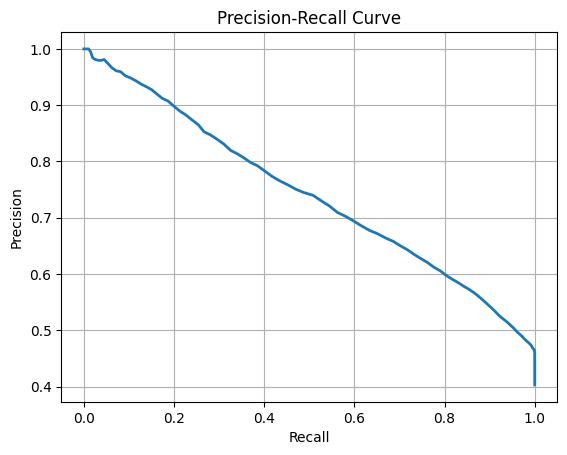

In [51]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()


C:\Users\thinkpad\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


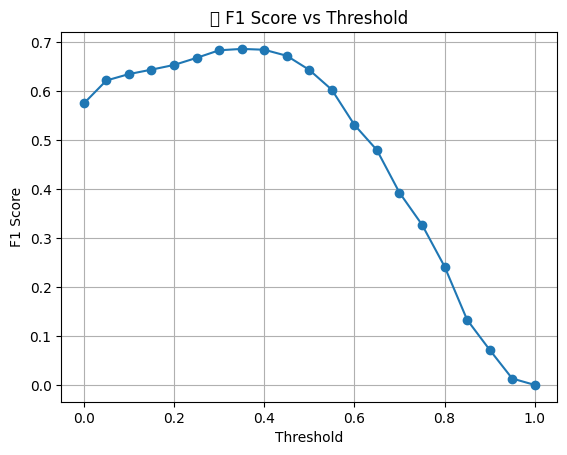

In [28]:
import numpy as np

thresholds = np.arange(0.0, 1.01, 0.05)
scores = []

for t in thresholds:
    y_pred_custom = (y_prob >= t).astype(int)
    from sklearn.metrics import f1_score
    scores.append(f1_score(y_test, y_pred_custom))

plt.plot(thresholds, scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('📌 F1 Score vs Threshold')
plt.grid()
plt.show()


In [29]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[15759  3147]
 [ 5344  7421]]
              precision    recall  f1-score   support

           0       0.75      0.83      0.79     18906
           1       0.70      0.58      0.64     12765

    accuracy                           0.73     31671
   macro avg       0.72      0.71      0.71     31671
weighted avg       0.73      0.73      0.73     31671



In [23]:
print(y.value_counts(normalize=True))


heart_attack
0    0.598996
1    0.401004
Name: proportion, dtype: float64


In [31]:
df['heart_attack'].value_counts(normalize=True)


heart_attack
0    0.598996
1    0.401004
Name: proportion, dtype: float64

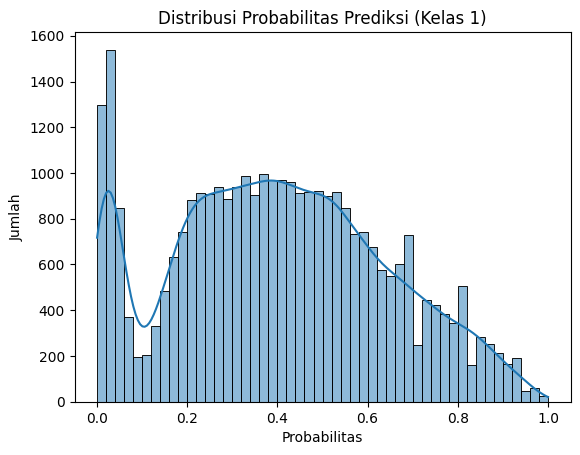

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

probas = model.predict_proba(X_test)[:, 1]
sns.histplot(probas, bins=50, kde=True)
plt.title("Distribusi Probabilitas Prediksi (Kelas 1)")
plt.xlabel("Probabilitas")
plt.ylabel("Jumlah")
plt.show()


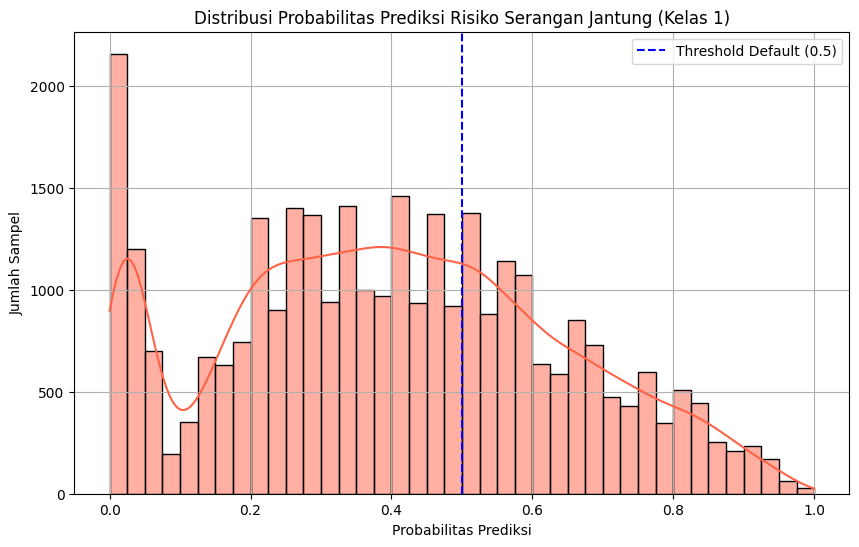

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil probabilitas prediksi untuk kelas 1 (risiko tinggi)
probas = model.predict_proba(X_test)[:, 1]

# Visualisasikan distribusinya
plt.figure(figsize=(10, 6))
sns.histplot(probas, bins=40, kde=True, color="tomato")
plt.title("Distribusi Probabilitas Prediksi Risiko Serangan Jantung (Kelas 1)")
plt.xlabel("Probabilitas Prediksi")
plt.ylabel("Jumlah Sampel")
plt.axvline(0.5, color="blue", linestyle="--", label="Threshold Default (0.5)")
plt.legend()
plt.grid(True)
plt.show()


In [37]:
from sklearn.metrics import classification_report

# Threshold manual
threshold = 0.4
y_pred_custom = (probas > threshold).astype(int)

print(f"Evaluasi dengan threshold = {threshold}")
print(classification_report(y_test, y_pred_custom))


Evaluasi dengan threshold = 0.4
              precision    recall  f1-score   support

           0       0.80      0.70      0.75     18906
           1       0.63      0.75      0.68     12765

    accuracy                           0.72     31671
   macro avg       0.72      0.72      0.72     31671
weighted avg       0.73      0.72      0.72     31671



In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test)


c:\Users\thinkpad\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
import pandas as pd
from app.prediction import load_model, predict_heart_attack
from app.preprocessing import preprocess_input

# ========== PASIEN RISIKO TINGGI ==========
high_risk_patient = {
    'age': 75,
    'gender': 'Male',
    'hypertension': 1,
    'diabetes': 1,
    'cholesterol_level': 320,
    'cholesterol_hdl': 30,
    'cholesterol_ldl': 200,
    'triglycerides': 300,
    'waist_circumference': 120,
    'blood_pressure_systolic': 185,
    'blood_pressure_diastolic': 120,
    'fasting_blood_sugar': 160,
    'EKG_results': 'Abnormal',
}


df_high = pd.DataFrame([high_risk_patient])
df_high_processed = preprocess_input(df_high, mode="predict")

model = load_model()
pred_high, prob_high = predict_heart_attack(model, df_high_processed)

print("🧪 [PASIEN 1: Risiko Tinggi]")
print("📋 Prediksi:", "Risiko Tinggi" if pred_high == 1 else "Risiko Rendah")
print("🔍 Probabilitas:", round(prob_high * 100, 2), "%\n")


# ========== PASIEN RISIKO RENDAH ==========
low_risk_patient = {
    "age": 30,
    "gender": "Female",
    "smoking_status": "Non-smoker",
    "systolic_bp": 110,
    "cholesterol_hdl": 60,
    "cholesterol_ldl": 90,
    "physical_activity": "High",
    "EKG_results": "Normal",
    "alcohol_consumption": "None",
    "air_pollution_exposure": "Low"
}

df_low = pd.DataFrame([low_risk_patient])
df_low_processed = preprocess_input(df_low, mode="predict")

pred_low, prob_low = predict_heart_attack(model, df_low_processed)

print("🧪 [PASIEN 2: Risiko Rendah]")
print("📋 Prediksi:", "Risiko Tinggi" if pred_low == 1 else "Risiko Rendah")
print("🔍 Probabilitas:", round(prob_low * 100, 2), "%")


🧪 [PASIEN 1: Risiko Tinggi]
📋 Prediksi: Risiko Tinggi
🔍 Probabilitas: 60.0 %

🧪 [PASIEN 2: Risiko Rendah]
📋 Prediksi: Risiko Rendah
🔍 Probabilitas: 18.0 %
